# Hotele na wakacje

## Wstępna ocena przydatności danych

In [12]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import CategoricalNB
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)

sns.set()

In [13]:
df = pd.read_csv('hotels.csv', index_col='id')

In [14]:
df.describe()

,latitude,longitude,ranking,ranking_out_of,rating,num_reviews,photo_count,amenities_count,awards_count
count,1165.000000,1165.000000,1165.00000,1165.000000,1165.000000,1165.000000,1165.000000,1165.000000,1165.000000
mean,31.607489,35.995338,147.04206,597.191416,4.337339,1929.244635,1560.814592,68.399142,0.842060
std,6.851927,19.677281,155.82979,372.791391,0.508456,2405.844558,2328.728259,40.316077,0.949289
min,24.816820,2.070631,1.00000,1.000000,2.500000,1.000000,0.000000,0.000000,0.000000
25%,25.220015,27.138655,24.00000,218.000000,4.000000,219.000000,168.000000,40.000000,0.000000
50%,27.907465,34.327927,81.00000,553.000000,4.500000,1073.000000,596.000000,61.000000,1.000000
75%,38.424140,55.266380,242.00000,982.000000,4.500000,2607.000000,1857.000000,96.000000,2.000000
max,41.435448,55.662610,697.00000,1202.000000,5.000000,15221.000000,13798.000000,208.000000,4.000000


In [15]:
df.select_dtypes(exclude=["number"]).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1165 entries, 1006161 to 9865057
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         1165 non-null   object
 1   city         1165 non-null   object
 2   region       1165 non-null   object
 3   country      1165 non-null   object
 4   brand        487 non-null    object
 5   price_level  1165 non-null   object
dtypes: object(6)
memory usage: 63.7+ KB


## Przygotowanie danych

In [16]:
df.price_level.value_counts()

$$      544
$       301
$$$     174
$$$$    146
Name: price_level, dtype: int64

In [17]:
str(round(len(df.loc[df.price_level == '$$']) / len(df), 4) * 100) + '%'

'46.7%'

In [18]:
df['price_level_num'] = df.price_level.apply(len)

<Axes: xlabel='price_level_num', ylabel='Count'>

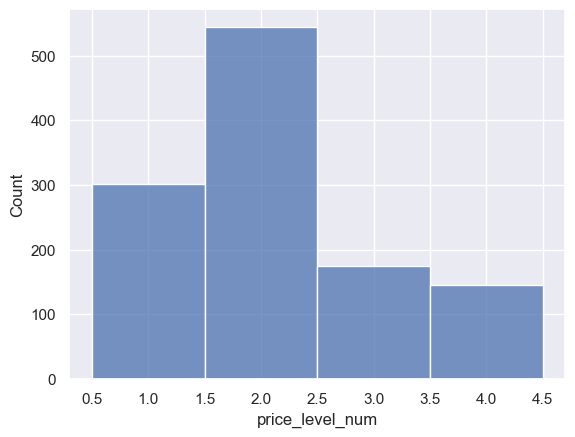

In [19]:
sns.histplot(data=df, x="price_level_num", discrete=True)

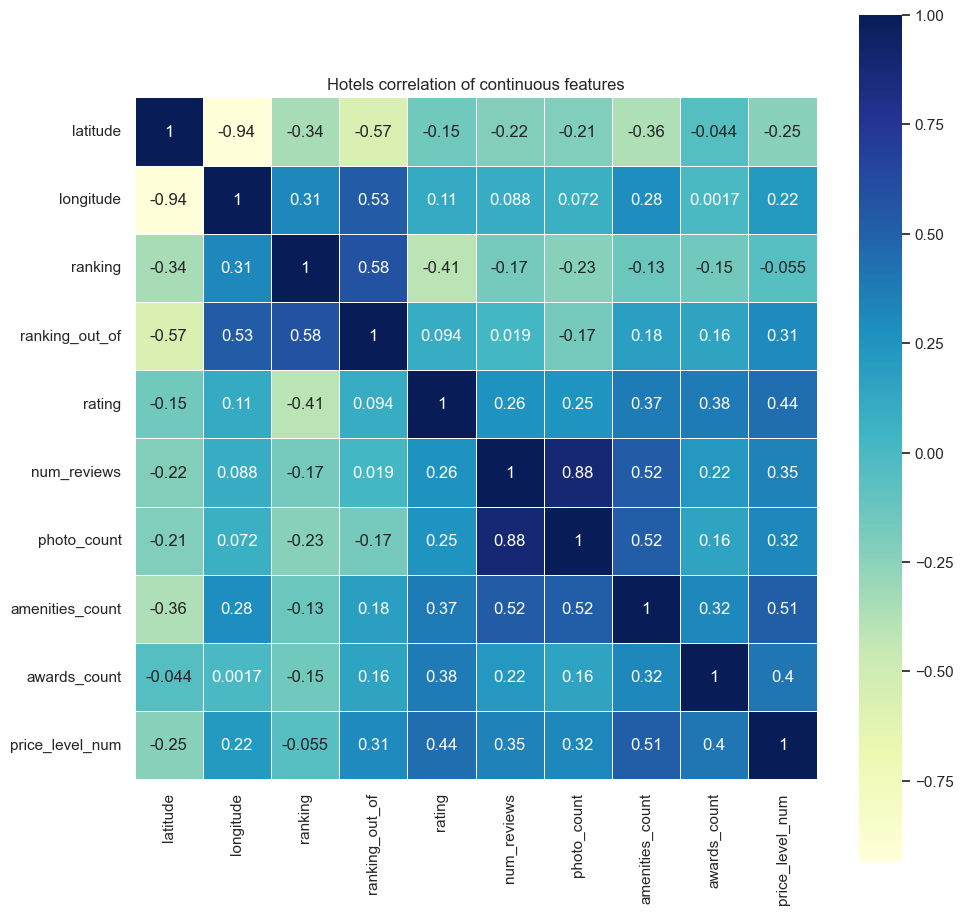

In [20]:
plt.subplots(figsize=(11, 11))
plt.title('Hotels correlation of continuous features')
ax = sns.heatmap(df.select_dtypes(include='number').corr(), 
                 annot=True, 
                 linewidths=.5, 
                 cmap="YlGnBu",
                 square=True
                );

`ranking` ma najmniejszą korelację

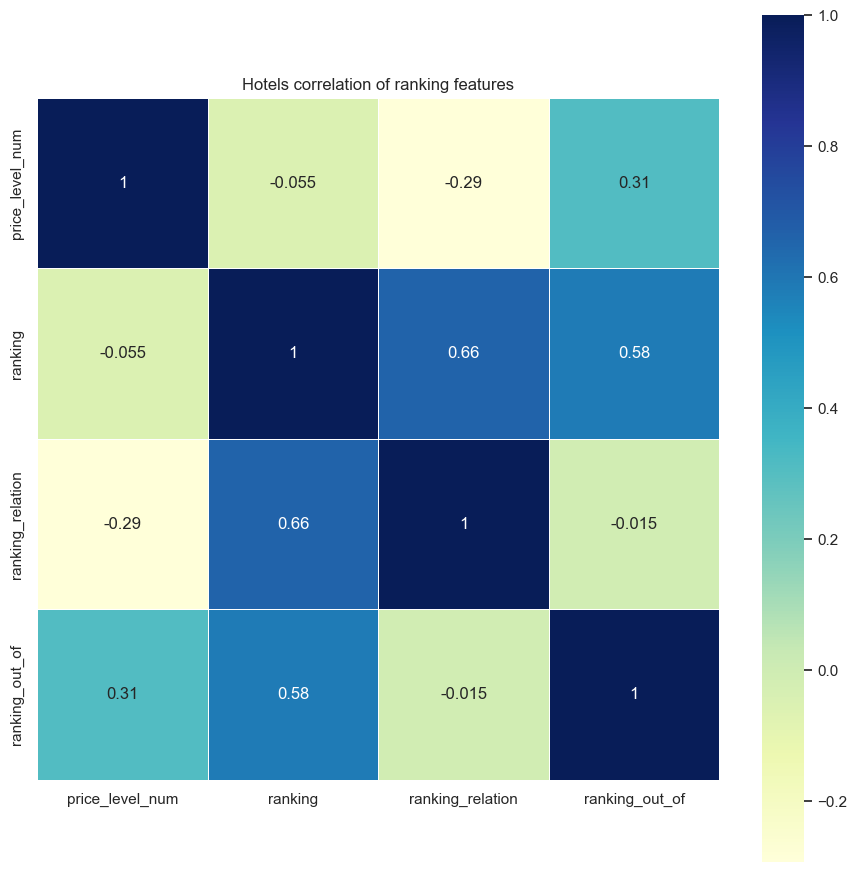

In [21]:
plt.subplots(figsize=(11, 11))
plt.title('Hotels correlation of ranking features')
df['ranking_relation'] = round(df.ranking / df.ranking_out_of, 2)
ax = sns.heatmap(df[['price_level_num', 'ranking', 'ranking_relation', 'ranking_out_of']].corr(), 
                 annot=True, 
                 linewidths=.5, 
                 cmap="YlGnBu",
                 square=True
                );


`ranking_relation` ma lepszą korelację za `ranking`

In [22]:
# dropped Y's low correlation ranking and name
X = df.drop(['price_level', 'price_level_num', 'ranking', 'name'], axis= 'columns')
X = pd.get_dummies(X)
X_scaled = minmax_scale(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df.price_level_num, test_size=0.2, random_state=1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
X_train.shape, X_validation.shape, X_test.shape

((745, 233), (187, 233), (233, 233))

## Modelowanie

In [23]:
df.price_level_num.value_counts(normalize=True)

2    0.466953
1    0.258369
3    0.149356
4    0.125322
Name: price_level_num, dtype: float64

Algorytm naiwny zawsze wybierając 2 będzie miał 47% dokładności

In [24]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_validation)

print(classification_report(y_validation, y_pred))

              precision    recall  f1-score   support

           1       0.63      0.62      0.63        53
           2       0.61      0.78      0.68        91
           3       0.20      0.19      0.19        16
           4       1.00      0.11      0.20        27

    accuracy                           0.59       187
   macro avg       0.61      0.43      0.43       187
weighted avg       0.64      0.59      0.56       187



55% na dobry początek

In [25]:
knn2 = KNeighborsClassifier()
param_grid = {"n_neighbors": np.arange(1, 50)}
knn_gscv = GridSearchCV(knn2, param_grid, cv=10)
knn_gscv.fit(X_train, y_train)
knn_gscv.best_params_, knn_gscv.best_score_

({'n_neighbors': 5}, 0.5947027027027028)

In [26]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_validation)
confusion_matrix(y_validation, y_pred)

array([[36, 15,  2,  0],
       [20, 68,  3,  0],
       [ 0, 13,  3,  0],
       [ 2, 15,  8,  2]], dtype=int64)

In [27]:
print(classification_report(y_validation, y_pred))

              precision    recall  f1-score   support

           1       0.62      0.68      0.65        53
           2       0.61      0.75      0.67        91
           3       0.19      0.19      0.19        16
           4       1.00      0.07      0.14        27

    accuracy                           0.58       187
   macro avg       0.61      0.42      0.41       187
weighted avg       0.63      0.58      0.55       187



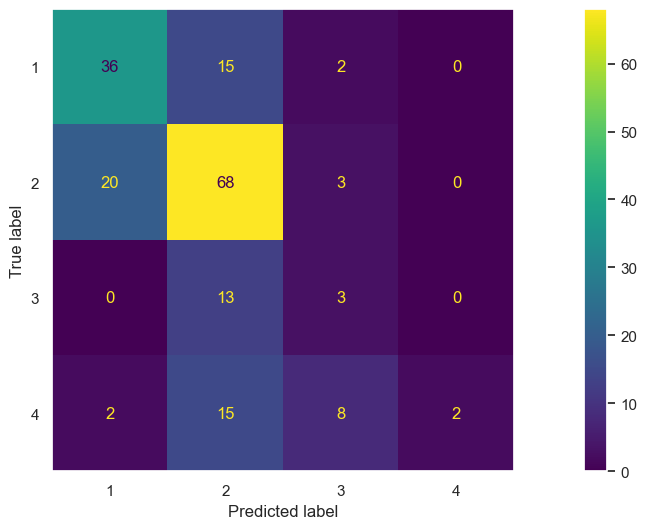

In [28]:
c_matrix = confusion_matrix(y_validation, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = c_matrix, display_labels=sorted(list(set(y_test))))
fig, ax = plt.subplots(figsize=(18, 6))
ax.grid(False)
cm_display.plot(ax=ax)
plt.show()

In [29]:
clf = LogisticRegression(random_state=1, solver='sag').fit(X_train, y_train)
y_pred = clf.predict(X_validation)
clf.score(X_validation, y_validation)

0.6256684491978609

In [30]:
print(classification_report(y_validation, y_pred))

              precision    recall  f1-score   support

           1       0.66      0.58      0.62        53
           2       0.62      0.79      0.69        91
           3       0.38      0.31      0.34        16
           4       0.90      0.33      0.49        27

    accuracy                           0.63       187
   macro avg       0.64      0.51      0.54       187
weighted avg       0.65      0.63      0.61       187



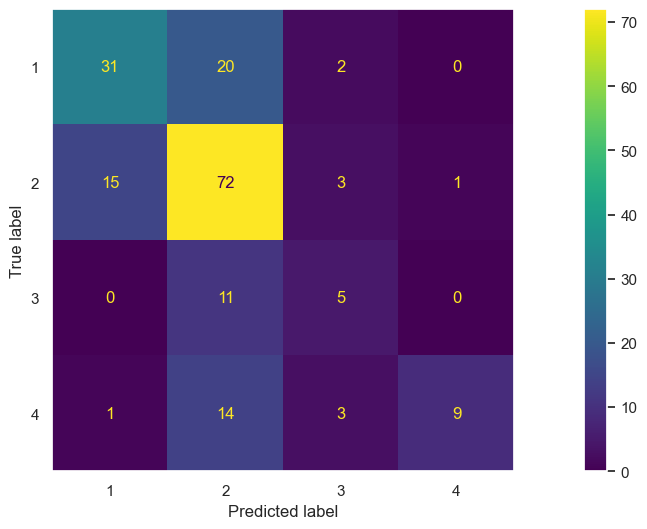

In [31]:
c_matrix = confusion_matrix(y_validation, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = c_matrix, display_labels=sorted(list(set(y_test))))
fig, ax = plt.subplots(figsize=(18, 6))
ax.grid(False)
cm_display.plot(ax=ax)
plt.show()

In [32]:
X_df = df.drop(['price_level', 'price_level_num', 'ranking', 'name'], axis= 'columns')
enc = OrdinalEncoder()
X_df.brand.fillna('no brand', inplace=True)
X = enc.fit_transform(X_df)
# X_scaled = minmax_scale(X)
X_train, X_test, y_train, y_test = train_test_split(X, df.price_level_num, test_size=0.2, random_state=1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
X_train.shape, X_validation.shape, X_test.shape

((745, 13), (187, 13), (233, 13))

In [33]:
df.nunique()

name                1163
city                  45
region                 6
country                5
latitude            1148
longitude           1153
ranking              478
ranking_out_of        49
rating                 6
num_reviews          929
photo_count          877
amenities_count      173
brand                168
awards_count           5
price_level            4
price_level_num        4
ranking_relation      83
dtype: int64

In [34]:
clf = CategoricalNB(min_categories=X_df.nunique())
clf.fit(X_train, y_train)
y_pred = clf.predict(X_validation)

print(classification_report(y_validation, y_pred))

              precision    recall  f1-score   support

           1       0.55      0.60      0.58        53
           2       0.64      0.62      0.63        91
           3       0.30      0.56      0.39        16
           4       0.55      0.22      0.32        27

    accuracy                           0.55       187
   macro avg       0.51      0.50      0.48       187
weighted avg       0.57      0.55      0.55       187



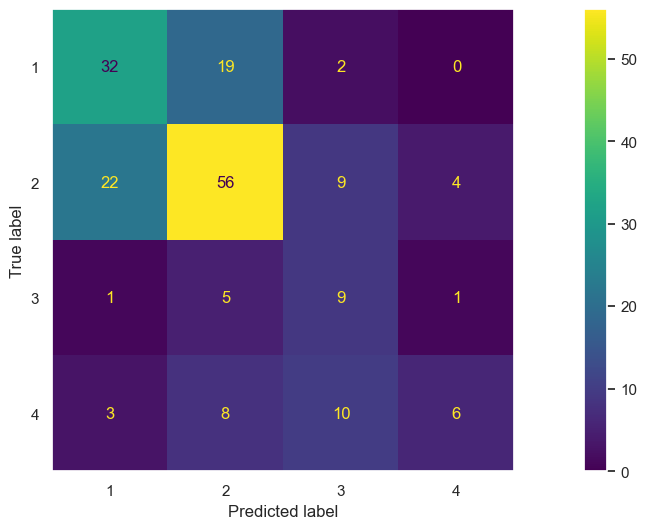

In [35]:
c_matrix = confusion_matrix(y_validation, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = c_matrix, display_labels=sorted(list(set(y_test))))
fig, ax = plt.subplots(figsize=(18, 6))
ax.grid(False)
cm_display.plot(ax=ax)
plt.show()

In [36]:
# dropped Y's low correlation ranking and name
X = df.drop(['price_level', 'price_level_num', 'ranking', 'name'], axis= 'columns')
X = pd.get_dummies(X)
X_scaled = minmax_scale(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df.price_level_num, test_size=0.2, random_state=1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [37]:
lda = LDA(store_covariance=True)
lda.fit(X_train, y_train)
lda_pred = lda.predict(X_validation)

In [38]:
print(classification_report(y_validation, lda_pred))

              precision    recall  f1-score   support

           1       0.63      0.58      0.61        53
           2       0.58      0.66      0.62        91
           3       0.20      0.25      0.22        16
           4       0.40      0.22      0.29        27

    accuracy                           0.54       187
   macro avg       0.45      0.43      0.43       187
weighted avg       0.54      0.54      0.53       187



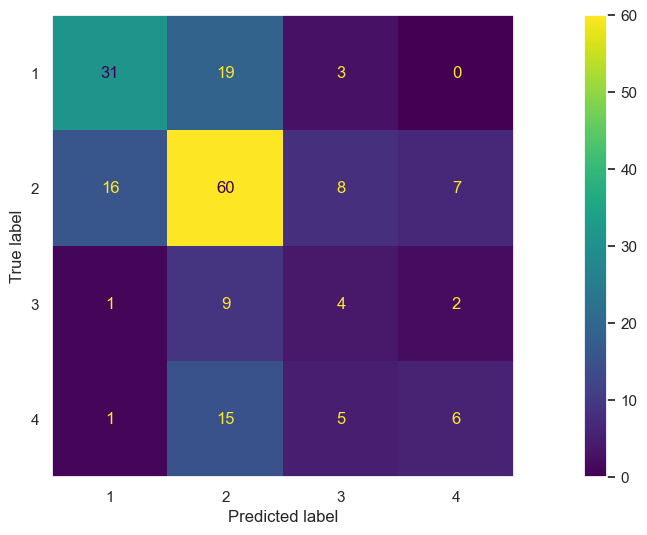

In [39]:
c_matrix = confusion_matrix(y_validation, lda_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = c_matrix, display_labels=sorted(list(set(y_test))))
fig, ax = plt.subplots(figsize=(18, 6))
ax.grid(False)
cm_display.plot(ax=ax)
plt.show()

In [40]:
qda = QDA(store_covariance=True)
qda.fit(X_train, y_train)
qda_pred = lda.predict(X_validation)
print(classification_report(y_validation, lda_pred))

              precision    recall  f1-score   support

           1       0.63      0.58      0.61        53
           2       0.58      0.66      0.62        91
           3       0.20      0.25      0.22        16
           4       0.40      0.22      0.29        27

    accuracy                           0.54       187
   macro avg       0.45      0.43      0.43       187
weighted avg       0.54      0.54      0.53       187



c:\Users\marko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


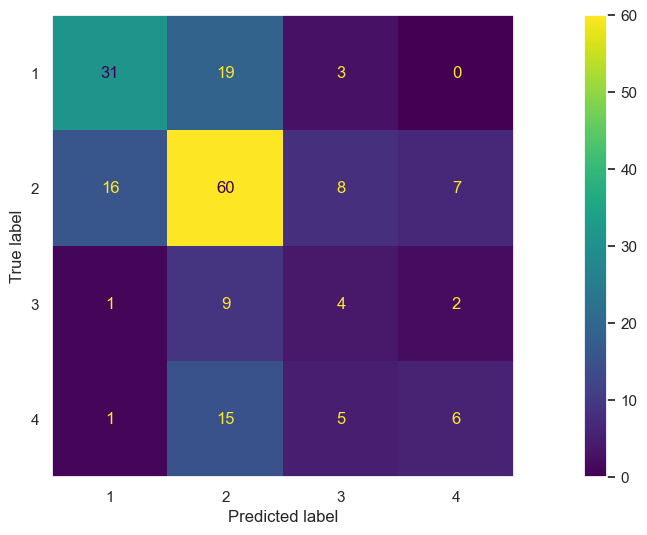

In [41]:
c_matrix = confusion_matrix(y_validation, qda_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = c_matrix, display_labels=sorted(list(set(y_test))))
fig, ax = plt.subplots(figsize=(18, 6))
ax.grid(False)
cm_display.plot(ax=ax)
plt.show()